"""
This script is used to produce and analyze data to make Figures 1A of the manuscript
'Plasmid-mediated phenotypic noise leads to transient antibiotic resistance in bacteria'.

MIT License

Copyright (c) 2023 JCRHB/RPM

""";


## Mount Gdrive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install Julia in server

In [2]:
# Installation cell
%%capture
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    wget -q 'https://julialang-s3.julialang.org/bin/linux/x64/1.7/julia-1.7.2-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'

echo 'Done'

In [3]:
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 15 not upgraded.
Need to get 2,433 kB of archives.
After this operation, 7,694 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2 [2,037 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgail18 amd64 2.24.33-2ubuntu2 [15.9 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64

## Restart session to load Julia kernel

Go to Colab's menu bar and select **Edit** and select **Notebook settings** from the drop down. Select *Julia 1.7* in Runtime type. \\
Note: if you change hardware acceleration will restart whole session (need to reinstall Julia).







##### Checking Julia version

In [4]:
VERSION

NameError: ignored

### Installing Figure specific modules

In [1]:
#using Pkg;ENV["JUPYTER"]="/usr/local/bin/python"; pkg"add Distributions,Plots,StatsBase,PyPlot;precompile"
using Pkg; pkg"add Distributions,StatsBase,PyCall,Plots,PyPlot;precompile"


    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Calculus ───────────────────── v0.5.1
   Installed Libmount_jll ───────────────── v2.35.0+0
   Installed x265_jll ───────────────────── v3.5.0+0
   Installed JpegTurbo_jll ──────────────── v2.1.91+0
   Installed libfdk_aac_jll ─────────────── v2.0.2+0
   Installed GR_jll ─────────────────────── v0.72.10+0
   Installed HypergeometricFunctions ────── v0.3.23
   Installed StatsFuns ──────────────────── v1.3.0
   Installed Xorg_xkbcomp_jll ───────────── v1.4.6+0
   Installed Opus_jll ───────────────────── v1.3.2+0
   Installed RelocatableFolders ─────────── v1.0.1
   Installed LoggingExtras ──────────────── v1.0.3
   Installed Unitful ────────────────────── v1.19.0
   Installed Grisu ──────────────────────── v1.0.2
   Installed PDMats ─────────────────────── v0.11.30
   Installed ConcurrentUtilities ────────── v2.3.0
   Installed Measures ───────────────────── v0.3.2
   Installed Conto

## Load ABM model

In [2]:
#%%julia

rootDir=pwd()*"/drive/MyDrive/"
rootDir=pwd()*"/drive/MyDrive/SYNC_Projects/"

rootDir=rootDir*"pBGT/GIT/"

source_path=rootDir*"code/ABM/source/"
pathData=rootDir*"data/sim_data/"
pathFigures=rootDir*"figures/"

#push!(LOAD_PATH,source_path)
source_path

"/content/drive/MyDrive/SYNC_Projects/pBGT/GIT/code/ABM/source/"

In [3]:
#%%julia

using Distributed
using Serialization
using Distributions,StatsBase,Printf,Random
#import GR

#using LaTeXStrings
#using StatsPlots
using PyCall
using PyPlot,Plots

#using Colors

#Plots.scalefontsizes(1.25)
#Plots.backend()

ntx = pyimport("networkx")
plt = pyimport("matplotlib.pyplot")
pyplot()

Plots.PyPlotBackend()

In [4]:
#%%julia

include(source_path*"ModelParameters.jl")
include(source_path*"Bacterias.jl")
include(source_path*"CellularFunctions.jl")
include(source_path*"Simulator.jl")
include(source_path*"AnalysisFunctions.jl")
include(source_path*"PlottingFunctions.jl")


### Run Simulation

In [5]:
#%%julia


starting_variation=true
aA=0.
R0=1.
rep_delay=3
degAA=1e-20
kNoise_dist=Normal(0.,.01)
pulse_start=3.5
pulse_end=5
T3=60*6

pulse_start=2.5
pulse_end=4
T3=60*5


time_mins3=collect(1:T3)

iniCells=1
bst=getInitialPopulation(iniCells, mu, 1,starting_variation);
sim_file3=pathData*"AntibioticPulse_sim-$(T3)min_IniCells-$(iniCells).bacsim"


cv=0.25
p_Ndist=Normal(mu,mu*cv)
antibiotic_action=.9


reDo_sim=false
#reDo_sim=true

if reDo_sim
    #this_bst2=Bacteria[]
    this_bst3=deepcopy(bst)
    lid=length(bst)

    println("Time\tTotal\tResource         .\tN alive")

    for ti in time_mins3

        ti==60*pulse_start ? (aA=pMIC*1;println("Introducing antibiotic")) : 0
        ti==60*pulse_end ? (aA=0.;println("Removing antibiotic")) : 0

        if ti%30==0
            tparam=0
            batp=0
            tdivs=[]
            for b in this_bst3
                b.isDead==false ? tparam+=1 : 0
                b.id==1 ? (batp=b.ATP;tdivs=b.divisions) : 0
            end
            println(ti/60,"\t",length(this_bst3),"\t",R0,"\t",tparam,"\t",aA,"\t",batp)#," ",tdivs./60)
            flush(stdout)
        end

        R0,aA,lid=simulate(ti, this_bst3, R0, aA,antibiotic_action,lid)

    end
    serialize(sim_file3, this_bst3);


else
    this_bst3=deserialize(sim_file3);

    print("Loaded saved simulation at $(sim_file3)")
end



Loaded saved simulation at /content/drive/MyDrive/SYNC_Projects/pBGT/GIT/data/sim_data/AntibioticPulse_sim-300min_IniCells-1.bacsim

# Analyzing simulation


In [6]:
#%%julia

survivors3=get_Pseries_survivours_indexs(this_bst3)
killed3=get_Pseries_killed_indexs(this_bst3,60*(pulse_start+.5),60*pulse_end)

println("Got $(length(survivors3)) founder survivors")
println("Got $(length(killed3)) founders killed")

Got 0 founder survivors
Got 1 founders killed


# Creating Graph object using networkx
#### roots refers to the starting population
#### node colors are created independently so they can be modified at will, this function colores them by PCN in a green scale

## Making Graph using all nodes

In [7]:
#%%julia
bs_roots,max_plasmids,min_plasmids,max_lvl,n_cells=get_Graph_data(this_bst3)

bs_GA=make_Graph_All(this_bst3,time_mins3)
list_colorsA=get_node_colorsSharp(bs_GA,min_plasmids,max_plasmids)
list_sizesA=get_node_sizes(bs_GA);

#### this part removes self connections "loops" created on division events
loops=[]
for (u,v) in bs_GA.edges
    u == v ?  push!(loops,u) : 0
    end
for l in loops
    bs_GA.remove_edge(l,l)
end

Max PCN: 28
Min PCN: 2
Roots: Any["1.30"]
N cells: 101
Max lvls: 9


#### calculating node positions

In [8]:
#%%julia

# sizey=Int(ceil(max_lvl/10)*10)
# sizex=Int(round(n_cells*.25))
# println(sizex," ",sizey)
nsz=Int(round(10000/n_cells))
# println(nsz)

nodes_positionsA=ntx.nx_agraph.graphviz_layout(bs_GA,prog= "dot",args="-Grankdir=TB -Gsplines=false -Gnodesep=.5 -Goverlap=scalexy",root="0-0")   #progs dot, twopi, fdp, sfdp, circo

;

#### Finding dead cells ( tree leaves)

In [9]:
#%%julia

startposy=[]
endposy=[]
for (k,v) in nodes_positionsA
    kid,kt=split(k,"-")
    x,y=v
    kt=parse(Int,kt)
    kt==Int(pulse_start*60) ? push!(startposy,y) : 0
    kt==Int(pulse_end*60) ? push!(endposy,y) : 0
end
pulse_ymin=minimum(endposy)
pulse_ymax=maximum(startposy)

leaves = []
dead_leaves=[]
alive_leaves=[]
for (v, d) in bs_GA.out_degree()
    if d == 0
    push!(leaves,v)
        n,t=split(v,"-")
        parse(Int,t)<Int(pulse_end*60) ? push!(dead_leaves,v) : push!(alive_leaves,v)
    end
end

dead_xs=[]
dead_ys=[]
for this_dead in dead_leaves
    xd,yd=nodes_positionsA[this_dead]
    push!(dead_xs,xd)
    push!(dead_ys,yd)
end




### calulating meassurements for plot aes

In [10]:
#%%julia


xx,yy=nodes_positionsA["1-1"]
timeEndy=yy

y_ends=[]
for this_leave in alive_leaves
    xx,yy=nodes_positionsA[this_leave]
    push!(y_ends,yy)
end
time0y=mean(y_ends)
time0y,timeEndy

newtimeEndy=trunc(timeEndy/100)*100
println(newtimeEndy)

newticks=collect(0:newtimeEndy/10:newtimeEndy)
newticks=Int.(newticks)

timeticks=collect(0:30:time_mins3[end])
#push!(timeticks,Int(pulse_start*60))
#push!(timeticks,Int(pulse_end*60))
sort!(timeticks)

m=(0-newtimeEndy)/(time_mins3[end]-0)
b=newtimeEndy+300
f(x)=m*x+b

newticks2=[]
for t in timeticks
    yt=f(t)
    push!(newticks2,yt)
end
reverse!(newticks2)


22100.0


11-element Vector{Any}:
   300.0
  2510.0
  4720.0
  6929.999999999998
  9140.0
 11350.0
 13560.0
 15770.0
 17980.0
 20190.0
 22400.0

In [60]:
pulse_ymin

4482.0

Saving figure /content/drive/MyDrive/SYNC_Projects/pBGT/GIT/figures/Fig-1A.pdf ..


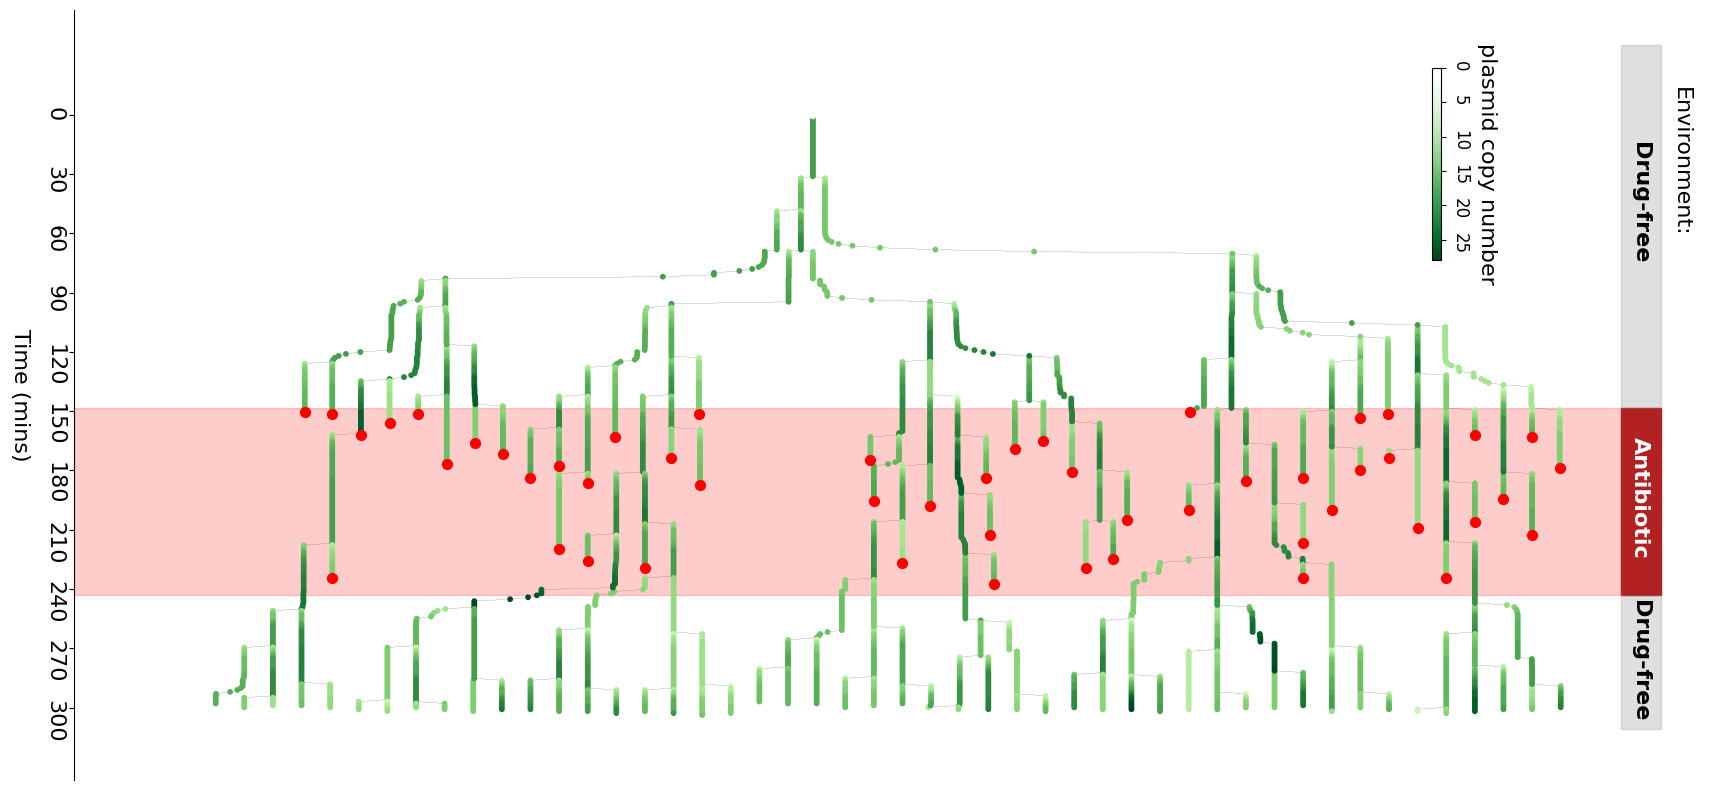

In [98]:

fig=plt.figure(figsize=(20,10))
fig.set_facecolor("white")
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16
cmap=plt.cm.Greens

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = min_plasmids, vmax=max_plasmids))
sm._A = []

#ax=ntx.draw_networkx(bs_GA,nodes_positionsA,node_size=nsz./10,node_color=list_colorsA,width=0.1,arrowsize=7,font_size=8,arrows=false,with_labels=false)
ax=ntx.draw_networkx(bs_GA,nodes_positionsA,node_size=nsz./10,node_color=list_colorsA,width=0.1,font_size=8,arrows=false,with_labels=false)
#plt.axis("off")
axs = plt.gca()
axs.tick_params(left=true, bottom=false, labelleft=true, labelbottom=false)
#axs.tick_params(axis="both", left="off", top=false, right="off", bottom="off", labelleft="off", labeltop="off", labelright="off", labelbottom="off")

axs.set_yticks(newticks2)
newtickslabels=reverse(timeticks)
axs.set_yticklabels(newtickslabels,rotation=270)

axs.spines["right"].set_visible(false)
axs.spines["top"].set_visible(false)
axs.spines["bottom"].set_visible(false)


axs.axhspan(ymin=pulse_ymin, ymax=pulse_ymax, xmin=0, xmax=0.95,color="red",alpha=0.2)

axs.axhspan(ymin=pulse_ymin, ymax=pulse_ymax, xmin=0.95, xmax=0.975,color="firebrick",alpha=1)
axs.axhspan(ymin=-500, ymax=pulse_ymin, xmin=0.95, xmax=0.975,color="gray",alpha=0.25)
axs.axhspan(ymin=pulse_ymax, ymax=25000, xmin=0.95, xmax=0.975,color="gray",alpha=0.25)

axs.scatter(dead_xs,dead_ys,s=50,c="r",zorder=3)#,marker="x")
axs.set_ylabel("Time (mins)",rotation=270, labelpad=25)

xanot=5325
axs.annotate("Environment:", (xanot+150,18000),fontsize=16,rotation=270)
axs.annotate("Drug-free", (xanot,17000),fontsize=16,fontweight="bold",rotation=270)
axs.annotate("Antibiotic", (xanot,6000),fontsize=16,fontweight="bold",rotation=270,color="w")
axs.annotate("Drug-free", (xanot,-50),fontsize=16,fontweight="bold",rotation=270)
#axs.annotate("Environment", (10,.85),fontsize=10,fontweight="bold",rotation=270)




cbar=plt.colorbar(sm,shrink=.25,fraction=0.05,pad=-0.1,anchor=(-1.7,0.9))
cbar.ax.set_yticks([0, 5, 10, 15, 20, 25])
cbar.ax.set_yticklabels([0, 5, 10, 15, 20, 25],rotation=270,fontsize=12)
cbar.ax.set_ylabel("plasmid copy number",rotation=270,labelpad=20)
cbar.ax.invert_yaxis()

figname=pathFigures*"Fig-1A.pdf"
println("Saving figure $figname ..")
plt.savefig(figname,bbox_inches = "tight",pad_inches = 0.1)
plt.show()
